In [3]:
import matplotlib
import copy
import logging
#import torch

#from tqdm.autonotebook import tqdm

from data.data_loader import Dataset
from data.germeval2017 import germeval2017_dataset

from misc.preferences import PREFERENCES
#from misc.visualizer import *
from misc.run_configuration import get_default_params, randomize_params
from misc import utils

from optimizer import get_default_optimizer
from criterion import NllLoss, LossCombiner

from models.transformer.encoder import TransformerEncoder
from models.softmax_output import SoftmaxOutputLayerWithCommentWiseClass
from models.transformer_tagger import TransformerTagger
from models.jointAspectTagger import JointAspectTagger
from models.transformer.train import Trainer
import pprint

In [4]:
PREFERENCES.defaults(
    data_root='./data/germeval2017',
    data_train='train_v1.4.tsv',    
    data_validation='dev_v1.4.tsv',
    data_test='test_TIMESTAMP1.tsv',
    early_stopping='highest_5_F1'
)
def load(hp, logger):
    dataset = Dataset(
        'germeval',
        logger,
        hp,
        source_index=0,
        target_vocab_index=2,
        data_path=PREFERENCES.data_root,
        train_file=PREFERENCES.data_train,
        valid_file=PREFERENCES.data_validation,
        test_file=PREFERENCES.data_test,
        file_format='.tsv',
        init_token=None,
        eos_token=None
    )
    dataset.load_data(germeval2017_dataset, verbose=False)
    return dataset

In [5]:
def load_model(dataset, hp, experiment_name):
    loss = LossCombiner(4, dataset.class_weights, NllLoss)
    transformer = TransformerEncoder(dataset.source_embedding,
                                     hyperparameters=hp)
    tagging_softmax = SoftmaxOutputLayerWithCommentWiseClass(hp.model_size, dataset.target_size)
    model = JointAspectTagger(transformer, hp.model_size, 4, 20, dataset.target_names)
    optimizer = get_default_optimizer(model, hp)
    trainer = Trainer(
                        model,
                        loss,
                        optimizer,
                        hp,
                        dataset,
                        experiment_name,
                        enable_tensorboard=False,
                        verbose=False)
    return trainer

In [6]:
experiment_name = 'HyperParameterTest'
use_cuda = True

In [7]:
# get general logger just for search
experiment_name = utils.create_loggers(experiment_name=experiment_name)
logger = logging.getLogger(__name__)
logger.info('Run hyper parameter random grid search for experiment with name ' + experiment_name)

Log path is  /data/home/felix/ABSA-Transformer/logs/HyperParameterTest/20190223/4


In [8]:
utils.get_current_git_commit()
logger.info('Current commit: ' + utils.get_current_git_commit())

In [9]:
num_optim_iterations = 25
logger.info('num_optim_iterations: ' + str(num_optim_iterations))

In [10]:
random_grid_search_ranges = {
    'batch_size': (1, 80),
    'num_encoder_blocks': (1, 10),
    'pointwise_layer_size': (32, 4000),
    'clip_comments_to': (12, 500),
    'learning_rate': (0, 1e-2),
    'learning_rate_factor': (1e-3, 4),
    'learning_rate_warmup': (1000, 10000),
    'optim_adam_beta1': (0.5, 0.99),
    'optim_adam_beta2': (0.5, 0.99),
    'dropout_rate': (0, 0.8),
    'transformer_config': {
        'transformer_heads': [1, 2, 3, 4, 5, 6, 10, 12, 15, 20]
    }
}
logger.info(pprint.pformat(random_grid_search_ranges, indent=2))

In [11]:
default_hp = get_default_params(use_cuda)
default_hp.num_epochs = 25
default_hp.seed = None
logger.info(default_hp)
print(default_hp)

+------------------------------------+
|          Hyperparameters           |
+-------------------------+----------+
|        Parameter        |  Value   |
+-------------------------+----------+
|        batch_size       |    12    |
|        model_size       |   300    |
|    learning_rate_type   |   noam   |
|      learning_rate      |    0     |
|   learning_rate_warmup  |   4800   |
|   learning_rate_factor  |    2     |
|     optim_adam_beta1    |   0.9    |
|     optim_adam_beta2    |   0.98   |
|      early_stopping     |    5     |
|         use_cuda        |   True   |
|       n_enc_blocks      |    3     |
|         n_heads         |    6     |
|           d_k           |    50    |
|           d_v           |    50    |
|       dropout_rate      |   0.1    |
|   pointwise_layer_size  |   2048   |
| log_every_xth_iteration |    -1    |
|        num_epochs       |    25    |
|      embedding_type     | fasttext |
|      embedding_name     |    6B    |
|      embedding_dim     



+-------------------------------------------------+
Optim Iteration: 0


+-------------------------------------------------+
|                 Hyperparameters                 |
+-------------------------+-----------------------+
|        Parameter        |         Value         |
+-------------------------+-----------------------+
|        batch_size       |           8           |
|        model_size       |          300          |
|    learning_rate_type   |          noam         |
|      learning_rate      | 0.0011657210564608288 |
|   learning_rate_warmup  |   7873.552714474266   |
|   learning_rate_factor  |  0.15117973392094078  |
|     optim_adam_beta1    |   0.5316564360707892  |
|     optim_adam_beta2    |   0.5378184321445757  |
|      early_stopping     |           5           |
|         use_cuda        |          True         |
|       n_enc_blocks      |           2           |
|         n_heads         |           3           |
|           d_k           |          100 

pre_training - DEBUG - 20 initialized
pre_training - DEBUG - Initilize parameters with nn.init.xavier_uniform_
pre_training - DEBUG - Tagger initialized


Epoch 1: 100%|██████████| 2131/2131 [04:11<00:00, 10.52it/s]

# EP	# IT	tr loss		val loss	f1		acc		duration / total time
1	2131	263.58		33.29		0.229		0.795		4.19m - 4.2m / 0.0m


Epoch 3:   0%|          | 1/2131 [08:17<43:48:09, 74.03s/it]

2	4262	130.82		44.45		0.217		0.727		4.10m - 8.3m / 104.8m


Epoch 3: 100%|██████████| 2131/2131 [12:23<00:00, 74.03s/it]   

3	6393	112.33		21.98		0.252		0.866		4.11m - 12.4m / 102.5m


Epoch 5:   0%|          | 1/2131 [16:26<43:48:09, 74.03s/it]   

4	8524	102.09		28.34		0.239		0.786		4.04m - 16.4m / 102.8m


Epoch 5: 100%|██████████| 2131/2131 [20:26<00:00, 74.03s/it]   

5	10655	89.87		24.66		0.253		0.829		4.00m - 20.4m / 101.2m


Epoch 6: 100%|██████████| 2131/2131 [24:26<00:00, 74.03s/it]   

6	12786	81.70		19.91		0.261		0.889		4.00m - 24.4m / 100.4m


Epoch 8:   0%|          | 1/2131 [28:25<43:48:09, 74.03s/it]   

7	14917	72.49		19.39		0.261		0.861		3.97m - 28.4m / 100.4m


Epoch 8: 100%|██████████| 2131/2131 [32:25<00:00, 74.03s/it]   

8	17048	69.26		19.78		0.266		0.881		4.00m - 32.4m / 99.9m


Epoch 9: 100%|██████████| 2131/2131 [36:24<00:00, 74.03s/it]   

9	19179	65.07		19.77		0.268		0.884		3.98m - 36.4m / 100.5m


Epoch 10: 100%|██████████| 2131/2131 [40:24<00:00, 74.03s/it]   

10	21310	64.51		16.38		0.269		0.897		3.99m - 40.4m / 100.1m


Epoch 12:   0%|          | 1/2131 [44:23<43:48:09, 74.03s/it]   

11	23441	59.72		18.51		0.268		0.870		3.97m - 44.4m / 100.3m


Epoch 12: 100%|██████████| 2131/2131 [48:22<00:00, 74.03s/it]   

12	25572	56.44		15.10		0.270		0.896		3.98m - 48.4m / 100.0m


Epoch 13: 100%|██████████| 2131/2131 [52:21<00:00, 74.03s/it]   

13	27703	53.62		16.23		0.270		0.881		3.98m - 52.4m / 100.1m


Epoch 15:   0%|          | 0/2131 [56:21<43:49:23, 74.03s/it]   

14	29834	48.56		16.82		0.267		0.873		4.00m - 56.4m / 100.1m


Epoch 15: 100%|██████████| 2131/2131 [1:00:21<00:00, 74.03s/it] 

15	31965	44.18		12.69		0.279		0.905		3.99m - 60.4m / 100.3m


Epoch 17:   0%|          | 0/2131 [1:04:21<43:49:23, 74.03s/it]   

16	34096	40.73		12.10		0.277		0.902		4.01m - 64.4m / 100.3m


Epoch 18:   0%|          | 1/2131 [1:08:21<43:48:09, 74.03s/it]   

17	36227	36.98		11.91		0.273		0.905		3.99m - 68.4m / 100.4m


Epoch 18: 100%|██████████| 2131/2131 [1:12:18<00:00, 74.03s/it]   

18	38358	37.31		11.47		0.284		0.908		3.95m - 72.3m / 100.3m


Epoch 20:   0%|          | 1/2131 [1:16:16<43:48:09, 74.03s/it]   

19	40489	34.00		12.26		0.278		0.896		3.97m - 76.3m / 100.0m


Epoch 21:   0%|          | 2/2131 [1:20:15<43:46:55, 74.03s/it]   

20	42620	33.16		12.92		0.278		0.873		3.98m - 80.3m / 100.1m


Epoch 22:   0%|          | 2/2131 [1:24:13<43:46:55, 74.03s/it]   

21	44751	32.25		13.61		0.277		0.880		3.97m - 84.2m / 100.1m


Epoch 22: 100%|██████████| 2131/2131 [1:28:12<00:00, 74.03s/it]   

22	46882	32.29		12.76		0.286		0.883		3.98m - 88.2m / 100.1m


Epoch 24:   0%|          | 0/2131 [1:32:12<43:49:23, 74.03s/it]   

23	49013	32.39		12.93		0.281		0.894		4.00m - 92.2m / 100.2m


Epoch 24: 100%|██████████| 2131/2131 [1:36:13<00:00, 74.03s/it]   

24	51144	33.15		12.11		0.288		0.913		4.00m - 96.2m / 100.2m


Epoch 25: 100%|██████████| 2131/2131 [1:40:12<00:00, 74.03s/it]   

25	53275	33.05		12.05		0.288		0.910		3.99m - 100.2m / 100.2m


+-------------------------------------------------+
Best Valid Result: 0.3268054296292514
+-------------------------------------------------+


###################################################



+-------------------------------------------------+
Optim Iteration: 1


+-------------------------------------------------+
|                 Hyperparameters                 |
+-------------------------+-----------------------+
|        Parameter        |         Value         |
+-------------------------+-----------------------+
|        batch_size       |           78          |
|        model_size       |          300          |
|    learning_rate_type   |          noam         |
|      learning_rate      | 0.0027784034103142275 |
|   learning_rate_warmup  |    3198.2461104295    |
|   learning_rate_factor  |   1.9678624417114878  |
|     optim_adam_beta1    |   0.661937245881485   |
|     optim_adam_beta2    |   0.792089380122234   |
|      early_stopping     |           5           |


pre_training - DEBUG - 20 initialized
pre_training - DEBUG - Initilize parameters with nn.init.xavier_uniform_
pre_training - DEBUG - Tagger initialized


Epoch 1: 100%|██████████| 219/219 [03:25<00:00,  1.22it/s]

# EP	# IT	tr loss		val loss	f1		acc		duration / total time
1	219	1170.77		113.63		0.168		0.490		3.42m - 3.4m / 0.0m


Epoch 2: 100%|██████████| 219/219 [06:51<00:00,  1.22it/s]

2	438	580.41		86.63		0.184		0.546		3.44m - 6.9m / 85.5m


Epoch 3: 100%|██████████| 219/219 [10:18<00:00,  1.22it/s]

3	657	506.29		56.12		0.215		0.658		3.44m - 10.3m / 86.0m


Epoch 4: 100%|██████████| 219/219 [13:43<00:00,  1.22it/s]

4	876	456.94		49.97		0.215		0.670		3.42m - 13.7m / 86.0m


Epoch 5: 100%|██████████| 219/219 [17:08<00:00,  1.22it/s]

5	1095	416.07		75.05		0.218		0.652		3.40m - 17.1m / 85.5m


Epoch 6: 100%|██████████| 219/219 [20:33<00:00,  1.22it/s]

6	1314	387.99		43.00		0.229		0.719		3.43m - 20.6m / 85.1m


Epoch 8:   0%|          | 0/219 [23:57<02:59,  1.22it/s]  

7	1533	346.41		49.74		0.218		0.669		3.39m - 24.0m / 85.6m


Epoch 8: 100%|██████████| 219/219 [27:21<00:00,  1.22it/s]

8	1752	336.74		38.90		0.237		0.742		3.40m - 27.4m / 85.0m


Epoch 9: 100%|██████████| 219/219 [30:49<00:00,  1.22it/s]

9	1971	309.31		40.83		0.249		0.765		3.45m - 30.8m / 85.2m


Epoch 10: 100%|██████████| 219/219 [34:12<00:00,  1.22it/s]

10	2190	275.33		47.44		0.255		0.769		3.39m - 34.2m / 86.0m


Epoch 12:   0%|          | 0/219 [37:36<02:59,  1.22it/s]  

11	2409	258.79		30.05		0.254		0.780		3.40m - 37.6m / 85.1m


Epoch 12: 100%|██████████| 219/219 [40:59<00:00,  1.22it/s]

12	2628	225.25		30.24		0.259		0.816		3.38m - 41.0m / 85.2m


Epoch 13: 100%|██████████| 219/219 [44:23<00:00,  1.22it/s]

13	2847	196.45		19.19		0.260		0.834		3.40m - 44.4m / 84.9m


Epoch 15:   0%|          | 0/219 [47:48<02:59,  1.22it/s]  

14	3066	168.70		22.68		0.247		0.793		3.40m - 47.8m / 85.2m


Epoch 15: 100%|██████████| 219/219 [51:13<00:00,  1.22it/s]

15	3285	123.22		18.88		0.261		0.799		3.41m - 51.2m / 85.3m


Epoch 17:   0%|          | 0/219 [54:35<02:59,  1.22it/s]  

16	3504	90.89		16.59		0.253		0.783		3.37m - 54.6m / 85.3m


Epoch 18:   0%|          | 0/219 [58:01<02:59,  1.22it/s]  

17	3723	60.43		13.75		0.254		0.780		3.43m - 58.0m / 84.9m


Epoch 18: 100%|██████████| 219/219 [1:01:25<00:00,  1.22it/s]

18	3942	40.95		11.49		0.265		0.807		3.40m - 61.4m / 85.4m


Epoch 19: 100%|██████████| 219/219 [1:04:46<00:00,  1.22it/s]

19	4161	31.68		12.57		0.269		0.801		3.35m - 64.8m / 85.2m


Epoch 21:   0%|          | 0/219 [1:08:08<02:59,  1.22it/s]  

20	4380	25.07		10.97		0.266		0.841		3.36m - 68.1m / 84.9m


Epoch 21: 100%|██████████| 219/219 [1:11:34<00:00,  1.22it/s]

21	4599	27.35		9.67		0.284		0.877		3.44m - 71.6m / 84.9m


Epoch 22: 100%|██████████| 219/219 [1:14:54<00:00,  1.22it/s]

22	4818	25.29		8.91		0.290		0.885		3.32m - 74.9m / 85.3m


Epoch 24:   0%|          | 0/219 [1:18:17<02:59,  1.22it/s]  

23	5037	21.90		9.65		0.284		0.870		3.38m - 78.3m / 84.9m


Epoch 25:   0%|          | 0/219 [1:21:35<02:59,  1.22it/s]  

24	5256	20.92		9.62		0.286		0.877		3.31m - 81.6m / 85.0m


Epoch 25: 100%|██████████| 219/219 [1:25:00<00:00,  1.22it/s]

25	5475	19.18		8.30		0.298		0.898		3.41m - 85.0m / 84.9m


+-------------------------------------------------+
Best Valid Result: 0.3330782401219957
+-------------------------------------------------+


###################################################



+-------------------------------------------------+
Optim Iteration: 2


+------------------------------------------------+
|                Hyperparameters                 |
+-------------------------+----------------------+
|        Parameter        |        Value         |
+-------------------------+----------------------+
|        batch_size       |          22          |
|        model_size       |         300          |
|    learning_rate_type   |         noam         |
|      learning_rate      | 0.009900575093264441 |
|   learning_rate_warmup  |  6359.775466708938   |
|   learning_rate_factor  |   1.79306569436184   |
|     optim_adam_beta1    |   0.9359787134166    |
|     optim_adam_beta2    |  0.655227539448646   |
|      early_stopping     |          5           |
|         use_

pre_training - DEBUG - 20 initialized
pre_training - DEBUG - Initilize parameters with nn.init.xavier_uniform_
pre_training - DEBUG - Tagger initialized


Epoch 1: 100%|██████████| 775/775 [06:05<00:00,  2.73it/s]

# EP	# IT	tr loss		val loss	f1		acc		duration / total time
1	775	69218178.19		15332337.13		0.165		0.535		6.09m - 6.1m / 0.0m


Epoch 2: 100%|██████████| 775/775 [11:57<00:00,  2.73it/s]

2	1550	nan		nan		0.240		0.944		5.85m - 12.0m / 152.4m


Epoch 4:   0%|          | 0/775 [17:44<04:43,  2.73it/s]  

3	2325	nan		nan		0.240		0.944		5.79m - 17.7m / 146.6m


Epoch 5:   0%|          | 0/775 [23:34<04:43,  2.73it/s]  

4	3100	nan		nan		0.240		0.944		5.82m - 23.6m / 145.1m


Epoch 6:   0%|          | 0/775 [29:25<04:43,  2.73it/s]  

5	3875	nan		nan		0.240		0.944		5.86m - 29.4m / 145.8m


Epoch 7:   0%|          | 0/775 [35:11<04:43,  2.73it/s]  

6	4650	nan		nan		0.240		0.944		5.75m - 35.2m / 146.6m


Epoch 7: 100%|██████████| 775/775 [40:54<00:00,  2.73it/s]


7	5425	nan		nan		0.240		0.944		5.73m - 40.9m / 144.5m

Valid Result: 0.3330782401219957



###################################################



+-------------------------------------------------+
Optim Iteration: 3


+------------------------------------------------+
|                Hyperparameters                 |
+-------------------------+----------------------+
|        Parameter        |        Value         |
+-------------------------+----------------------+
|        batch_size       |          22          |
|        model_size       |         300          |
|    learning_rate_type   |         noam         |
|      learning_rate      | 0.004667062686953772 |
|   learning_rate_warmup  |  7255.007208703063   |
|   learning_rate_factor  |  2.464618265231109   |
|     optim_adam_beta1    |  0.6767548445192131  |
|     optim_adam_beta2    |  0.6568842895120443  |
|      early_stopping     |          5           |
|         use_cuda        |         True         |
|       n_enc_bl

pre_training - DEBUG - 20 initialized
pre_training - DEBUG - Initilize parameters with nn.init.xavier_uniform_
pre_training - DEBUG - Tagger initialized


Epoch 1: 100%|██████████| 775/775 [01:42<00:00, 13.32it/s]

# EP	# IT	tr loss		val loss	f1		acc		duration / total time
1	775	82.77		26.13		0.214		0.794		1.71m - 1.7m / 0.0m


Epoch 2: 100%|██████████| 775/775 [03:25<00:00, 13.32it/s]

2	1550	50.83		13.18		0.245		0.871		1.71m - 3.4m / 42.8m


Epoch 4:   0%|          | 1/775 [05:09<00:58, 13.32it/s]  

3	2325	47.18		13.04		0.243		0.809		1.71m - 5.2m / 42.8m


Epoch 4: 100%|██████████| 775/775 [06:51<00:00, 13.32it/s]

4	3100	43.89		9.28		0.246		0.848		1.71m - 6.9m / 42.8m


Epoch 6:   0%|          | 1/775 [08:34<00:58, 13.32it/s]  

5	3875	38.12		13.97		0.238		0.807		1.71m - 8.6m / 42.7m


Epoch 7:   0%|          | 1/775 [10:17<00:58, 13.32it/s]  

6	4650	32.81		12.44		0.235		0.800		1.71m - 10.3m / 42.8m


Epoch 8:   0%|          | 1/775 [11:59<00:58, 13.32it/s]  

7	5425	27.96		12.94		0.240		0.775		1.71m - 12.0m / 42.8m


Epoch 8: 100%|██████████| 775/775 [13:41<00:00, 13.32it/s]

8	6200	21.26		7.71		0.262		0.863		1.71m - 13.7m / 42.8m


Epoch 9: 100%|██████████| 775/775 [15:24<00:00, 13.32it/s]

9	6975	14.37		5.05		0.274		0.939		1.71m - 15.4m / 42.7m


Epoch 10: 100%|██████████| 775/775 [17:07<00:00, 13.32it/s]

10	7750	14.66		6.27		0.274		0.913		1.71m - 17.1m / 42.8m


Epoch 12:   0%|          | 1/775 [18:50<00:58, 13.32it/s]  

11	8525	14.55		7.51		0.265		0.863		1.71m - 18.8m / 42.8m


Epoch 12: 100%|██████████| 775/775 [20:32<00:00, 13.32it/s]

12	9300	14.32		6.21		0.277		0.899		1.70m - 20.5m / 42.7m


Epoch 14:   0%|          | 1/775 [22:14<00:58, 13.32it/s]  

13	10075	13.71		9.74		0.246		0.799		1.69m - 22.2m / 42.7m


Epoch 15:   0%|          | 1/775 [23:57<00:58, 13.32it/s]  

14	10850	13.90		6.20		0.272		0.896		1.71m - 24.0m / 42.6m


Epoch 15: 100%|██████████| 775/775 [25:38<00:00, 13.32it/s]

15	11625	13.34		6.29		0.280		0.901		1.69m - 25.6m / 42.8m


Epoch 17:   0%|          | 1/775 [27:20<00:58, 13.32it/s]  

16	12400	13.18		8.12		0.260		0.849		1.69m - 27.3m / 42.6m


Epoch 18:   0%|          | 1/775 [29:03<00:58, 13.32it/s]  

17	13175	13.00		7.65		0.271		0.873		1.71m - 29.1m / 42.6m


Epoch 19:   0%|          | 1/775 [30:45<00:58, 13.32it/s]  

18	13950	12.69		7.74		0.266		0.850		1.70m - 30.8m / 42.7m


Epoch 20:   0%|          | 1/775 [32:27<00:58, 13.32it/s]  

19	14725	12.89		7.90		0.269		0.854		1.71m - 32.5m / 42.7m


Epoch 20: 100%|██████████| 775/775 [34:09<00:00, 13.32it/s]


20	15500	12.70		9.34		0.256		0.834		1.70m - 34.2m / 42.7m

Valid Result: 0.3330782401219957



###################################################



+-------------------------------------------------+
Optim Iteration: 4


+------------------------------------------------+
|                Hyperparameters                 |
+-------------------------+----------------------+
|        Parameter        |        Value         |
+-------------------------+----------------------+
|        batch_size       |          19          |
|        model_size       |         300          |
|    learning_rate_type   |         noam         |
|      learning_rate      | 0.006079812121101265 |
|   learning_rate_warmup  |  9020.521735852282   |
|   learning_rate_factor  | 0.05745533778662076  |
|     optim_adam_beta1    |  0.783681944746232   |
|     optim_adam_beta2    |  0.7054632733674455  |
|      early_stopping     |          5           |
|         use_cuda        |         True         |
|       n_en

pre_training - DEBUG - 20 initialized
pre_training - DEBUG - Initilize parameters with nn.init.xavier_uniform_
pre_training - DEBUG - Tagger initialized


Epoch 1: 100%|██████████| 897/897 [05:17<00:00,  3.22it/s]

# EP	# IT	tr loss		val loss	f1		acc		duration / total time
1	897	1187.78		85.03		0.185		0.547		5.29m - 5.3m / 0.0m


Epoch 2: 100%|██████████| 897/897 [10:34<00:00,  3.22it/s]

2	1794	221.05		63.55		0.195		0.580		5.27m - 10.6m / 132.3m


Epoch 3: 100%|██████████| 897/897 [15:55<00:00,  3.22it/s]

3	2691	198.25		52.01		0.203		0.620		5.35m - 15.9m / 131.8m


Epoch 5:   0%|          | 0/897 [21:12<04:38,  3.22it/s]  

4	3588	184.28		49.84		0.201		0.618		5.28m - 21.2m / 133.6m


Epoch 6:   0%|          | 1/897 [26:30<04:38,  3.22it/s]  

5	4485	179.65		47.85		0.203		0.622		5.29m - 26.5m / 132.2m


Epoch 6: 100%|██████████| 897/897 [31:49<00:00,  3.22it/s]

6	5382	174.39		43.34		0.207		0.637		5.31m - 31.8m / 132.3m


Epoch 7: 100%|██████████| 897/897 [37:09<00:00,  3.22it/s]

7	6279	174.35		41.34		0.208		0.659		5.34m - 37.2m / 132.7m


Epoch 9:   0%|          | 0/897 [42:26<04:38,  3.22it/s]  

8	7176	165.61		47.72		0.203		0.627		5.27m - 42.4m / 133.2m


Epoch 9: 100%|██████████| 897/897 [47:44<00:00,  3.22it/s]

9	8073	160.94		41.96		0.210		0.655		5.31m - 47.7m / 132.0m


Epoch 10: 100%|██████████| 897/897 [53:04<00:00,  3.22it/s]

10	8970	155.20		34.41		0.220		0.704		5.32m - 53.1m / 132.7m


Epoch 11: 100%|██████████| 897/897 [58:19<00:00,  3.22it/s]

11	9867	144.02		32.39		0.224		0.713		5.25m - 58.3m / 132.9m


Epoch 12: 100%|██████████| 897/897 [1:03:38<00:00,  3.22it/s]

12	10764	130.93		29.92		0.231		0.743		5.30m - 63.6m / 131.9m


Epoch 13: 100%|██████████| 897/897 [1:08:55<00:00,  3.22it/s]

13	11661	122.42		32.48		0.232		0.743		5.29m - 68.9m / 132.5m


Epoch 14: 100%|██████████| 897/897 [1:14:13<00:00,  3.22it/s]

14	12558	116.28		26.92		0.241		0.769		5.29m - 74.2m / 132.4m


Epoch 16:   0%|          | 0/897 [1:19:32<04:38,  3.22it/s]  

15	13455	110.84		30.74		0.235		0.736		5.32m - 79.5m / 132.4m


Epoch 16: 100%|██████████| 897/897 [1:24:48<00:00,  3.22it/s]

16	14352	101.11		26.70		0.252		0.803		5.26m - 84.8m / 132.7m


Epoch 18:   0%|          | 1/897 [1:30:10<04:38,  3.22it/s]  

17	15249	98.69		24.84		0.247		0.782		5.37m - 90.2m / 132.1m


Epoch 19:   0%|          | 0/897 [1:35:28<04:38,  3.22it/s]  

18	16146	96.74		25.84		0.248		0.771		5.30m - 95.5m / 133.1m


Epoch 20:   0%|          | 0/897 [1:40:49<04:38,  3.22it/s]  

19	17043	89.19		36.06		0.248		0.758		5.35m - 100.8m / 132.6m


Epoch 20: 100%|██████████| 897/897 [1:46:09<00:00,  3.22it/s]

20	17940	89.05		22.81		0.259		0.828		5.33m - 106.2m / 132.9m


Epoch 22:   0%|          | 0/897 [1:51:28<04:38,  3.22it/s]  

21	18837	82.38		25.19		0.253		0.791		5.31m - 111.5m / 132.8m


Epoch 23:   0%|          | 0/897 [1:56:47<04:38,  3.22it/s]  

22	19734	79.84		23.32		0.258		0.811		5.32m - 116.8m / 132.7m


Epoch 23: 100%|██████████| 897/897 [2:02:04<00:00,  3.22it/s]

23	20631	75.29		22.77		0.261		0.817		5.28m - 122.1m / 132.7m


Epoch 24: 100%|██████████| 897/897 [2:07:26<00:00,  3.22it/s]

24	21528	72.90		21.35		0.264		0.826		5.35m - 127.4m / 132.7m


Epoch 25: 100%|██████████| 897/897 [2:12:43<00:00,  3.22it/s]


25	22425	72.20		22.71		0.261		0.812		5.29m - 132.7m / 132.8m

Valid Result: 0.3330782401219957



###################################################



+-------------------------------------------------+
Optim Iteration: 5


+-----------------------------------------------+
|                Hyperparameters                |
+-------------------------+---------------------+
|        Parameter        |        Value        |
+-------------------------+---------------------+
|        batch_size       |          36         |
|        model_size       |         300         |
|    learning_rate_type   |         noam        |
|      learning_rate      | 0.00581362665130959 |
|   learning_rate_warmup  |  1651.3951648615953 |
|   learning_rate_factor  |  2.9588471664357647 |
|     optim_adam_beta1    |  0.5512446936700348 |
|     optim_adam_beta2    |  0.9681621628570081 |
|      early_stopping     |          5          |
|         use_cuda        |         True        |
|       n_enc_blocks    

pre_training - DEBUG - 20 initialized
pre_training - DEBUG - Initilize parameters with nn.init.xavier_uniform_
pre_training - DEBUG - Tagger initialized


Epoch 1: 100%|██████████| 474/474 [15:33<00:00,  1.49s/it]

# EP	# IT	tr loss		val loss	f1		acc		duration / total time
1	474	616.78		48.46		0.210		0.713		15.56m - 15.6m / 0.0m


Epoch 2: 100%|██████████| 474/474 [31:05<00:00,  1.49s/it]

2	948	400.15		30.74		0.217		0.732		15.52m - 31.1m / 389.0m


Epoch 3:  64%|██████▍   | 303/474 [40:17<04:13,  1.49s/it]


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

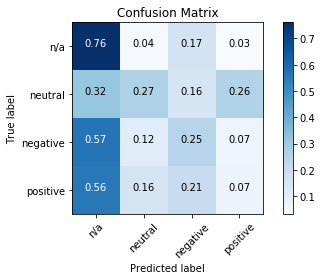

In [12]:
dataset_logger = logging.getLogger('data_loader')
best_f1 = 0.0
best_model = None
best_hp = None
best_iteration = -1
for optim_iteration in range(num_optim_iterations):
        
    print(f'\n\n+-------------------------------------------------+\nOptim Iteration: {optim_iteration}\n\n')
    logger.info(f'\n\n=================================\nOptim Iteration: {optim_iteration}\n=================================')
    
    # generate iteration hyper parameters
    hp = randomize_params(default_hp, random_grid_search_ranges)
        
    logger.info('New Params:')
    logger.info(hp)
    print(hp)
    
    logger.debug('Load dataset')
    dataset = load(hp, dataset_logger)
    logger.debug('dataset loaded')
    logger.debug('Load model')
    trainer = load_model(dataset, hp, experiment_name)
    logger.debug('model loaded')
    
    logger.debug('Begin training')
    model = None
    try:
        result = trainer.train(use_cuda=hp.use_cuda, perform_evaluation=False)
        model = result['model']
    except Exception as err:
        logger.exception("Could not complete iteration " + str(optim_iteration))
        print(f'Could not complete iteration {optim_iteration} because of {str(err)}')
        continue
        
    # perform evaluation and log results
    result = None
    try:
        result = trainer.perform_final_evaluation(use_test_set=False, verbose=False)
    except Exception as err:
        logger.exception("Could not complete iteration evaluation for it " + str(optim_iteration))
        print(f'Could not complete iteration {optim_iteration} evaluation because of {str(err)}')
        continue
    
    it_f1 = result[1][1]
    if best_f1 < it_f1:
        best_f1 = it_f1
        best_model = model
        best_hp = copy.copy(hp)
        best_iteration = optim_iteration
        print('+-------------------------------------------------+')
        print(f'Best Valid Result: {best_f1}')
        print('+-------------------------------------------------+')
    else:
        print(f'\nValid Result: {best_f1}\n')    
    print('\n\n###################################################\n')
    
print('Best iteration: ' + str(best_iteration))
print('Best f1: ' + str(best_f1))
print('Best HP:')
print(best_hp)